In [1]:
import os 
import sys
import pickle 

from glob import glob

import lasio
import welly 

import numpy as np
import pandas as pd

import missingno as msno

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.path.abspath("../scripts/"))
from utils import label2category, scale

In [3]:
%matplotlib inline

## Data Loading

In [4]:
fname = os.path.abspath("../data/well_logs_v2_filled.csv")
df = pd.read_csv(fname)
df.head()
df.drop(columns=["Unnamed: 0"], inplace=True)

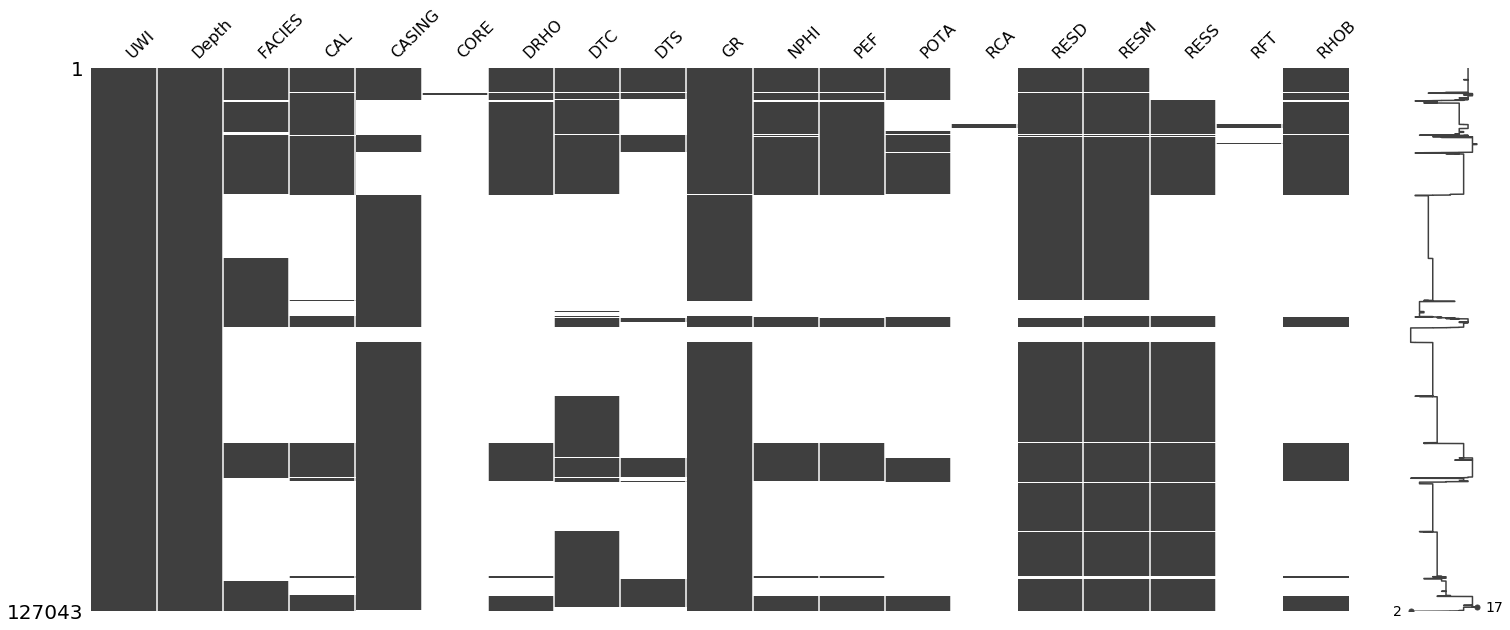

In [5]:
fig = msno.matrix(df)
# fig = ax.get_figure()
# fig.savefig("poseidon-msno.png")

## Data Cleaning

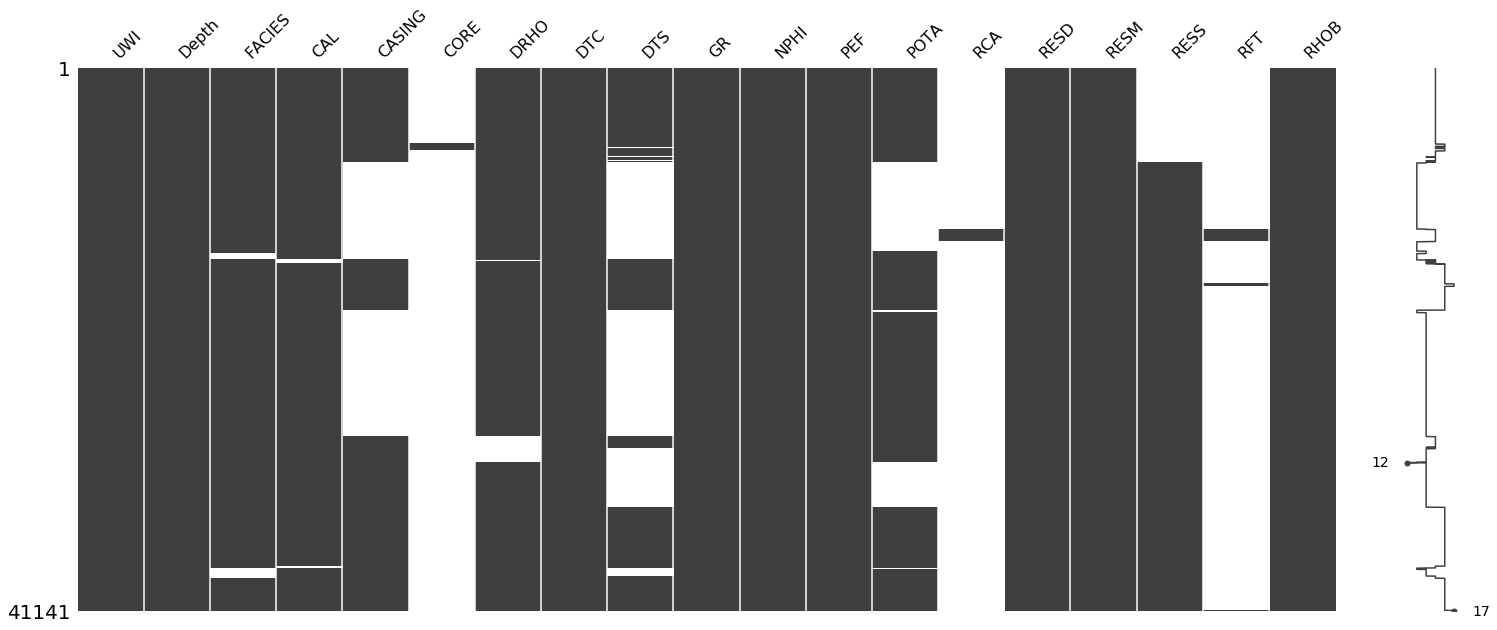

In [6]:
tracks = ["Depth", "GR", "DTC", "RESD", "RESM", "RHOB", "PEF", "NPHI"]
dft = df.dropna(subset=tracks, how="any")

_ = msno.matrix(dft)

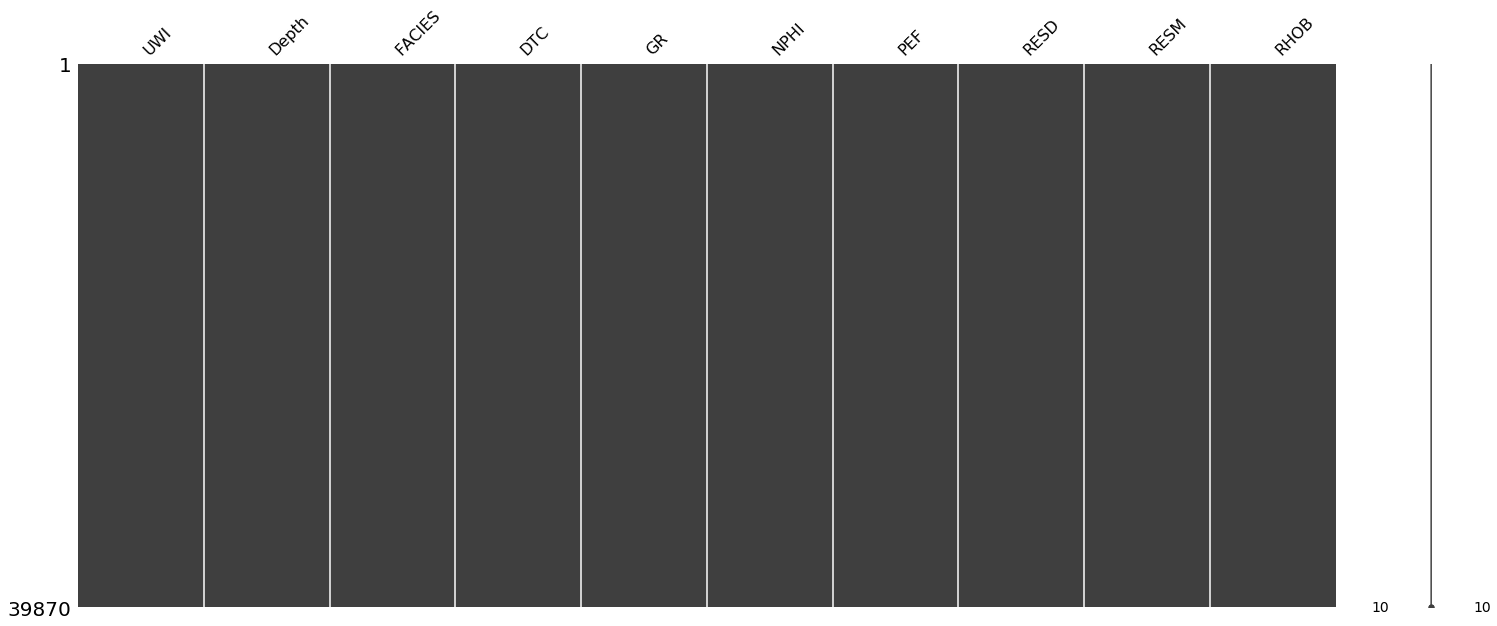

In [7]:
drop_tracks = ['CAL', 'CASING', 'CORE', 'DRHO', 'DTS', 'POTA', 'RCA', 'RESS', 'RFT']
dft = df.drop(columns=drop_tracks).dropna()
_ = msno.matrix(dft)

In [8]:
fname = os.path.abspath("../data/poseidon-all.csv")
dft = pd.read_csv(fname)
# dft.to_csv(fname)

In [9]:
dfw = []

for i, iw in enumerate(dft["UWI"].unique()):
    tw = dft[dft["UWI"]==iw].copy()
    tw.drop(columns=["Unnamed: 0"], inplace=True)
    dfw.append(tw)
#     tw.to_csv(os.path.abspath("../data/poseidon-"+str(i)+".csv"))

In [10]:
# tracks = ["GR", "DTC", "RESD", "RESM", "RHOB", "PEF", "NPHI"]
for iw in dfw:
    display(iw.describe())

,Depth,FACIES,DTC,GR,NPHI,PEF,RESD,RESM,RHOB
count,7217.000000,7217.000000,7217.000000,7217.000000,7217.000000,7217.000000,7217.000000,7217.000000,7217.000000
mean,4601.498592,2.004573,86.408987,101.891608,0.232146,8.052116,24.967417,24.551271,2.560582
std,330.319628,0.418338,13.107758,40.415820,0.091375,2.139538,151.844217,140.719830,0.085365
min,4042.105225,1.000000,51.621103,6.774285,0.005511,2.060357,0.573609,0.640140,2.272935
25%,4316.933440,2.000000,80.014876,82.636576,0.180664,8.281214,0.998820,0.974467,2.506113
50%,4593.742124,2.000000,89.890495,97.845998,0.265161,8.657058,1.675225,1.659843,2.549102
75%,4868.570340,2.000000,96.442958,138.547547,0.297568,9.132076,2.599811,2.557569,2.610941
max,5205.402481,4.000000,104.529629,192.626944,0.368107,23.306035,1950.000000,1947.873035,3.026037


,Depth,FACIES,DTC,GR,NPHI,PEF,RESD,RESM,RHOB
count,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000,6856.000000
mean,4057.809676,3.568116,78.887299,75.366271,0.214980,4.016124,27.572530,26.864156,2.575214
std,301.536089,1.891599,12.958671,28.160206,0.104148,0.967619,101.242117,346.265556,0.101865
min,3535.042993,1.000000,50.045424,24.372993,0.017580,1.621713,0.655797,0.725199,1.923913
25%,3796.731555,2.000000,70.875296,53.817983,0.136567,3.241163,1.986788,2.152132,2.531631
50%,4057.810743,3.000000,79.324314,69.083770,0.210093,3.946272,2.717959,2.918250,2.573369
75%,4318.889930,6.000000,87.548839,96.245990,0.287323,4.551821,13.417530,12.214881,2.615247
max,4579.969117,6.000000,114.562613,206.939315,0.635174,7.729896,2292.315557,22360.732890,3.412229


,Depth,FACIES,DTC,GR,NPHI,PEF,RESD,RESM,RHOB
count,3797.000000,3797.000000,3797.000000,3797.000000,3797.000000,3797.000000,3797.000000,3797.000000,3797.000000
mean,5014.965502,3.812220,68.101306,104.867014,0.166001,4.580267,29.393996,34.161059,2.644942
std,171.406985,1.573549,8.011735,47.120274,0.096635,1.830503,75.961102,99.686062,0.068774
min,4697.882324,1.000000,50.368496,13.556050,0.004564,2.025453,0.456209,0.433482,2.276841
25%,4873.077694,3.000000,62.265431,61.615505,0.082798,3.510074,4.417333,4.563249,2.636449
50%,5017.651960,4.000000,66.929193,110.143800,0.160477,4.016294,9.079926,9.296810,2.656558
75%,5162.226227,4.000000,74.565247,145.216164,0.231280,4.948601,20.906915,21.594542,2.677174
max,5306.800493,7.000000,98.134060,206.194765,0.561301,11.748430,1400.368306,1457.663335,2.853523


,Depth,FACIES,DTC,GR,NPHI,PEF,RESD,RESM,RHOB
count,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000,9572.000000
mean,4520.320564,3.262954,87.867199,96.957539,0.178438,6.470605,7.718428,11.049145,2.573397
std,421.192191,1.844412,15.830276,35.008961,0.069900,20.832668,26.826628,60.627704,0.109117
min,3782.720459,2.000000,48.640855,14.581142,0.002314,3.606758,0.504782,0.581019,1.824064
25%,4155.924683,2.000000,78.063276,78.237117,0.142705,4.928342,1.152672,1.149762,2.497441
50%,4520.445311,2.000000,92.464462,91.686657,0.189899,5.378482,1.966377,1.955461,2.534967
75%,4884.965938,3.000000,99.860747,122.951719,0.221246,6.260006,3.763627,3.808606,2.666758
max,5249.486565,8.000000,124.359730,176.072112,0.658610,1997.903462,884.331470,1799.790381,4.347037


,Depth,FACIES,DTC,GR,NPHI,PEF,RESD,RESM,RHOB
count,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000,1962.000000
mean,5078.679280,4.492864,66.435523,81.971195,0.118518,8.501866,194.068433,81.569432,2.638622
std,88.304844,1.644362,6.787966,53.309548,0.101512,11.140593,466.746595,144.474555,0.151158
min,4926.305198,2.000000,52.041690,7.766078,0.020316,2.256554,0.378764,0.380306,2.153755
25%,5000.991746,3.000000,61.376128,37.959880,0.053037,5.185081,9.033389,9.260562,2.546558
50%,5080.553295,4.000000,66.186721,75.709075,0.080920,6.561134,23.283453,23.281621,2.687304
75%,5155.239843,7.000000,70.223335,119.678524,0.152299,8.070669,69.501473,68.365821,2.739189
max,5229.926391,7.000000,91.364331,259.267019,0.578631,105.013496,1950.000000,1542.952599,3.030593


,Depth,FACIES,DTC,GR,NPHI,PEF,RESD,RESM,RHOB
count,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000,7967.000000
mean,4724.342818,2.540605,77.738560,85.210950,0.221885,7.373300,14.823537,17.932782,2.618645
std,351.905696,0.995509,12.970571,34.174927,0.099052,2.842547,31.497634,44.738639,0.094200
min,4115.720101,1.000000,47.561642,8.779669,0.027222,2.523683,0.671280,0.620106,2.340993
25%,4419.112778,2.000000,65.634603,65.787753,0.157770,5.248131,1.470525,1.455021,2.542268
50%,4726.009364,2.000000,77.975341,81.829751,0.220477,7.947219,3.288507,3.338055,2.597013
75%,5029.402041,3.000000,88.035886,104.389495,0.273462,8.596925,16.607499,17.533813,2.677801
max,5332.794719,7.000000,106.007188,235.616330,0.618893,57.220700,458.106149,790.027534,3.148911


,Depth,FACIES,DTC,GR,NPHI,PEF,RESD,RESM,RHOB
count,2499.000000,2499.000000,2499.000000,2499.000000,2499.000000,2499.000000,2499.000000,2499.000000,2499.000000
mean,4781.536147,3.595838,74.922198,95.601735,0.256772,5.592748,22.204603,27.013059,2.618858
std,110.189667,2.116294,12.515711,52.901464,0.136660,3.471519,69.054223,78.916722,0.093764
min,4591.072259,1.000000,51.039339,6.186510,0.022754,1.698516,0.293496,0.288707,2.302683
25%,4686.210962,2.000000,64.793796,50.712143,0.136611,3.906940,2.119769,2.136138,2.559306
50%,4781.349665,3.000000,71.277075,89.887796,0.261022,4.595061,7.408561,7.665456,2.621534
75%,4876.488368,4.000000,87.176167,145.623101,0.340108,6.147762,19.794105,22.727854,2.685075
max,4972.693478,7.000000,111.736298,222.097294,0.622227,82.952154,1859.572054,1835.379880,3.016653


## Model pre-processing

In [11]:
temp = np.copy(dfw[-1].values)

y_test = np.asarray(temp[:, 2], dtype=int)
x_test = temp[:, 3:]

temp = np.copy(dfw[0].values)

y_train = np.asarray(temp[:, 2], dtype=int)
x_train = temp[:, 3:]

for idf in dfw[1:-1]:
    temp = np.copy(idf.values)

    y_train = np.hstack((y_train, np.asarray(temp[:, 2], dtype=int)))
    x_train = np.vstack((x_train, temp[:, 3:]))

In [12]:
x_train = preprocessing.scale(x_train)
print("mu = {mean}; sigma = {std}".format(mean=x_train.mean(), std=x_train.std()))

mu = 2.2772395312685847e-16; sigma = 1.0000000000000002


/home/ro/apps/python/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## Model training

In [14]:
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [15]:
pickle.dump(model, open(os.path.abspath("../data/poseidon-model.dat"), "wb"))

## Model prediction

In [16]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 34.29%


/home/ro/apps/python/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
